In [5]:
# Codes below require the installation of pywindcal 
# Use version 1.0.7

!pip show pywincalc

Name: pywincalc
Version: 1.0.7
Summary: UNKNOWN
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: c:\users\administrator\anaconda3\lib\site-packages
Requires: 
Required-by: 


# Algothrim for estimating the SHGC of window system

In [1]:
import pickle
import pywincalc
import json

def main(glzid, coated, trans_factor, ref_factor, emissivity):   # Make everything in a function for the convenience of use
    glzid = glzid

    # Read in the origional glazing data from the database
    with open(r'C:\Users\Administrator\Desktop\onedrive\OneDrive - University of Toronto\window_database\{}.pkl'.format(glzid),'rb') as f:
        file_content = pickle.load(f)


    import json
    json_dict = json.loads(file_content.content)  # Convert string to JSON dictionary

    if coated:
        json_dict['coated_side'] = 'Back'
        ## Manually modify the spectral data of clear glazing for all wavelength
        for item in json_dict['spectral_data']['spectral_data']:
            item['T'] = item['T'] * trans_factor
            item['Rf'] = item['Rf'] * ref_factor

        json_dict['emissivity_back'] = emissivity
        ## Convert back to pywincalc object
        glz_str = json.dumps(json_dict).replace(r"'",r'"').replace("None", 'null').replace("True", "true").replace(" ",'').replace("False", "false")
        glz_obj = pywincalc.parse_json(glz_str)   
        return glz_obj
    else:
        uncoated = pywincalc.parse_json(file_content.content)

        return uncoated



# Validation

In [2]:
import pandas as pd

sdfsd= pd.read_csv('sdfsdfsdfsdfsdfsdfs.csv',index_col=0)


estimated = []


glz_obj = main(102, False, None, None)   
standard_path = r"C:\Program Files (x86)\LBNL\LBNL Shared\Standards\W5_NFRC_2003.std" 
standard = pywincalc.load_standard(standard_path)
window_system = pywincalc.Glazing_System([glz_obj] ,[],standard, 1,1 )  # Width and height are both set to 1 m for the validation purposes
estimated.append(window_system.shgc().result)



for item in zip(sdfsd['Estimated Reduction in Solar Transmittance'][1:], sdfsd['Estimated Increase in Solar Reflectance'][1:] ):
    glz_obj = main(102, True, *item)
    
    
    standard_path = r"C:\Program Files (x86)\LBNL\LBNL Shared\Standards\W5_NFRC_2003.std" 
    standard = pywincalc.load_standard(standard_path)

    window_system = pywincalc.Glazing_System([glz_obj] ,[],standard, 1,1 )  # Width and height are both set to 1 m for the validation purposes
    
    
    estimated.append(window_system.shgc().result)
    
    
    
 

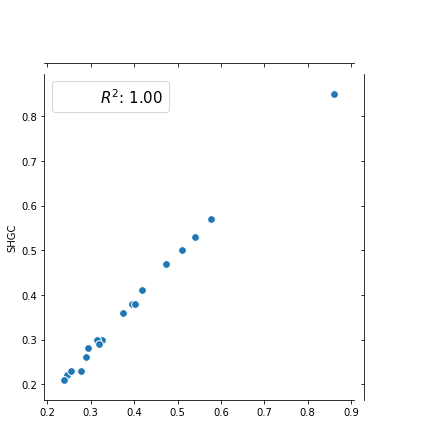

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

g = sns.JointGrid(estimated, sdfsd['SHGC'])
g = g.plot_joint(plt.scatter, s=60, edgecolor="white")
rsquare = lambda a, b: stats.pearsonr(a, b)[0] ** 2
g = g.annotate(rsquare, template="{stat}: {val:.2f}", stat="$R^2$", loc="upper left", fontsize=15)

Comments:
* Overall the model for SHGC estmiation shows a good agreement with what reported by the manufacture
* In the following steps, this model will be used to generate the estimated SHGC for double-glazed window.

# Generate the parameters used in simulations

In [2]:
def assembly(system_width, system_height, glaze_1, glaze_2, gap_1):


    system_area = system_width * system_height

    frame_wdith  = 53e-3  # value taken from ASHRAE fundamentals for Aluminum with thermal break. For operable window
    

    glazing_width  = system_width - frame_wdith * 2
    glazing_height = system_height - frame_wdith * 2

    frame_area = system_area - glazing_width * glazing_height


    edge_width = 65e-3  # value taken from ASHRAE fundamentals, Section Edge-of-glass U-factor

    glazing_center_area = (glazing_width - edge_width * 2) * (glazing_height - edge_width * 2)
    glazing_edge_area = glazing_width * glazing_height - glazing_center_area




    standard_path = r"C:\Program Files (x86)\LBNL\LBNL Shared\Standards\W5_NFRC_2003.std" 
    standard = pywincalc.load_standard(standard_path)


    gaps = [gap_1]
    solid_layers = [glaze_1,glaze_2]

    glazing_system_tripple_layer = pywincalc.Glazing_System(solid_layers, gaps, standard, system_width, system_height)
    center_u = glazing_system_tripple_layer.u().result
    glazing_SHGC = glazing_system_tripple_layer.shgc().result
    edge_u = (0.078+ 0.998 * (center_u/5.678263) -0.175*(center_u/5.678263) **2)*5.678263
    frame_u = 5.22   # ASHRAE Fundamentals
    overall_u = (center_u * glazing_center_area + frame_u * frame_area + edge_u * glazing_edge_area)/system_area

#     SHGC_frame = 0.9*frame_u/26
    frame_absrptivity = 0.7    # value taken from Calculating the Solar Heat Gain of Window Frames 
    
    hi = 8 + 4 * 5.67e-8 * 0.8 * (30 + 273.15)**3   # These are the summer conditions used in ISO 15099, formula ffrom ASHREA fundamentals, emissivity taken from Heat and Mass textbook for anodized aluminum
    SHGC_frame = frame_absrptivity * 0.49 * frame_u / hi  # Formula from ASHRAE Fundamental 
#     print(glazing_SHGC)
#     print(center_u)

    SHGC_overall = (SHGC_frame * frame_area + glazing_SHGC * (glazing_width * glazing_height))/system_area  # formula from ASHRAE fundamentals



    return overall_u, SHGC_overall


In [46]:

test_layer1 = main(265, False, None, None, None)   
test_layer2 = main(224, False, None, None, None)   


assembly(1,1,test_layer1,test_layer2,pywincalc.Gap_Data(pywincalc.Gas_Type.AIR, .0127))



0.43170822295806754
2.817916482320353


(3.3416691889602506, 0.38043844542951816)

In [3]:
import pandas as pd

sdfsd= pd.read_csv('sdfsdfsdfsdfsdfsdfs.csv',index_col=0)

U_keep = []
SHGC_keep = []


uncoated_layer = main(103, False, None, None, None)   

U_o, SHGC_o = assembly(4, 2.7, uncoated_layer, uncoated_layer, pywincalc.Gap_Data(pywincalc.Gas_Type.AIR, .0127))
# window_system = pywincalc.Glazing_System([uncoated_layer, uncoated_layer] ,[pywincalc.Gap_Data(pywincalc.Gas_Type.AIR, .0127)],standard, 4, 2.7 )  # Width and height are both set to 1 m for the validation purposes
U_keep.append(U_o)
SHGC_keep.append(SHGC_o)



for item in zip(sdfsd['Estimated Reduction in Solar Transmittance'][1:], sdfsd['Estimated Increase in Solar Reflectance'][1:], sdfsd['Emissivity'][1:] ):   # do calculation for all of the known films
    coated_layer = main(103, True, *item)
    U_o, SHGC_o = assembly(4, 2.7, coated_layer, uncoated_layer, pywincalc.Gap_Data(pywincalc.Gas_Type.AIR, .0127))
    U_keep.append(U_o)
    SHGC_keep.append(SHGC_o)
    

In [13]:
test_layer = estimated[8].solid_layers[1]

pywincalc.Glazing_System([test_layer], [], standard, 4, 2.7 ).shgc().result

0.3173028001241785

In [5]:
list_shgc = list(map(lambda x: x.shgc().result, estimated))

In [5]:
SHGC_keep

[0.6650091119074752,
 0.41862785817430953,
 0.38643460287191783,
 0.33104016833967165,
 0.26709672177921434,
 0.26481273881642003,
 0.17366954398606732,
 0.29137359959760056,
 0.2322066469380123,
 0.16803118491864946,
 0.37277770070765365,
 0.2665306443691121,
 0.16398980688381273,
 0.1776671817941028,
 0.15551558319678105,
 0.19617468584695166,
 0.2009776853148184,
 0.18862282721272952]